# Project: AI-generated text detection 🤖
--------------------------------

**Dr. Dave Wanik - (OPIM 5512: Data Science Using Python) AND (OPIM 5509: Introduction to Deep Learning) - University of Connecticut**

Can you predict the 'ind' (0= human, 1 = AI) as a function of the 768 document embeddings, the word count and the punctuation? Be careful - there is imbalanced data which may require some advanced methods in order to get a reasonable model. Can you beat a naive (majority class) model or logistic regression? Now is your time to shine and apply everything you learned.

This project is being given to both classes simultaneously - however, you should only use the methods taught in each class. DS students must use only `sklearn` models, DL students must use `keras` models taught in class. DS students may use `XGBoost()` if they want, but this is at their own risk. `autoML` and `autokeras` may be used to fit models, but students still must be rigorous in their evaluation of the models.

Come to office hours EARLY with any questions that might pop up. See end of notebook for rubric.


*   Team Member Names: Geethasree Madiraju Nagaraju, Hunjoo Lee, Pradeepti Dokka
*   Group Number: 7
* My best F1 score on the test data was: 0.69



In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Lasso
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

##Load Data

In [ ]:
import pandas as pd
!gdown 1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas

Downloading...
From: https://drive.google.com/uc?id=1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas
To: /content/ai-text-competition-data.zip
100% 50.8M/50.8M [00:00<00:00, 130MB/s]


In [ ]:
# unzip it
!unzip ai-text-competition-data.zip

# read it
df = pd.read_csv('/content/ai-text-competition/training_set.csv')

# 1.EDA

In [ ]:
df.shape

(11144, 772)

In [ ]:
df.head(5)

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
0,1,0.231980,-0.190620,-0.985933,-0.233773,-0.355879,-0.488884,0.254773,-0.121213,-0.820528,...,0.101373,0.575414,-0.567646,-0.051293,0.455840,0.065538,0.020671,25,14,0
1,2,0.168223,-1.204551,-0.596952,-0.722583,0.284799,-0.238639,-0.410948,-0.090654,1.220703,...,0.407270,0.769329,0.555820,0.252843,0.603888,1.240028,-0.076253,23,4,0
2,3,0.522005,-0.759933,-1.209413,0.301834,0.361126,0.158161,-0.117013,0.313158,1.102455,...,0.143658,0.874958,0.679421,0.393198,0.439103,0.742181,-0.430493,29,8,0
3,4,0.038746,-1.408335,-0.580810,0.353450,1.142353,-0.418879,-0.134133,-0.199796,1.071100,...,0.728436,0.540930,1.968447,0.185315,0.630167,0.577032,0.117681,14,3,0
4,5,-0.307572,0.103575,-0.368605,-0.378654,-0.285990,-0.508058,-0.254869,-0.108291,-0.095139,...,-0.146845,0.497731,-0.299924,-0.020024,0.975511,-0.342360,-0.428779,35,9,0


In [ ]:
# descriptive statistics of all the columns
df.describe()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
count,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,...,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000
mean,5572.500000,0.146012,-0.273505,-0.666907,-0.415562,-0.230934,-0.270790,-0.039869,-0.037003,0.101543,...,0.274985,0.687529,0.269849,0.199639,0.443093,0.078578,-0.062243,29.978643,7.347003,0.098708
std,3217.140034,0.389374,0.382566,0.432605,0.745149,0.583487,0.388663,0.292493,0.246509,0.503054,...,0.406760,0.431843,0.545066,0.304694,0.365657,0.551214,0.300848,10.271548,4.041350,0.298283
min,1.000000,-1.633110,-1.971542,-2.505377,-4.280401,-2.413613,-1.514833,-1.427118,-1.036038,-1.779871,...,-1.765492,-1.723701,-1.506003,-1.272904,-1.467510,-1.605773,-1.085949,5.000000,0.000000,0.000000
25%,2786.750000,-0.111816,-0.517288,-0.954874,-0.891329,-0.633606,-0.536751,-0.229016,-0.197038,-0.236033,...,-0.000389,0.392865,-0.125641,0.000539,0.208861,-0.303969,-0.273816,22.000000,4.000000,0.000000
50%,5572.500000,0.161513,-0.261028,-0.673000,-0.415641,-0.244129,-0.281473,-0.036129,-0.038384,0.068244,...,0.256874,0.683075,0.213906,0.205270,0.461389,0.021472,-0.074150,30.000000,7.000000,0.000000
75%,8358.250000,0.418461,-0.016541,-0.381686,0.078408,0.168207,-0.018891,0.157572,0.117311,0.399803,...,0.535327,0.981356,0.634109,0.400167,0.692926,0.405299,0.129446,38.000000,10.000000,0.000000
max,11144.000000,1.378549,1.376324,1.392311,2.184251,1.659698,1.667419,1.070739,1.320982,2.456948,...,1.987709,1.965830,2.582598,1.375909,1.879438,2.579186,1.674109,57.000000,27.000000,1.000000


In [ ]:
#check if there are any null values in any of the columns
df.isna().sum().sum()

0

In [ ]:
# target class distribution
df['ind'].value_counts()

0    10044
1     1100
Name: ind, dtype: int64

### Histograms of 20 word embeddings features

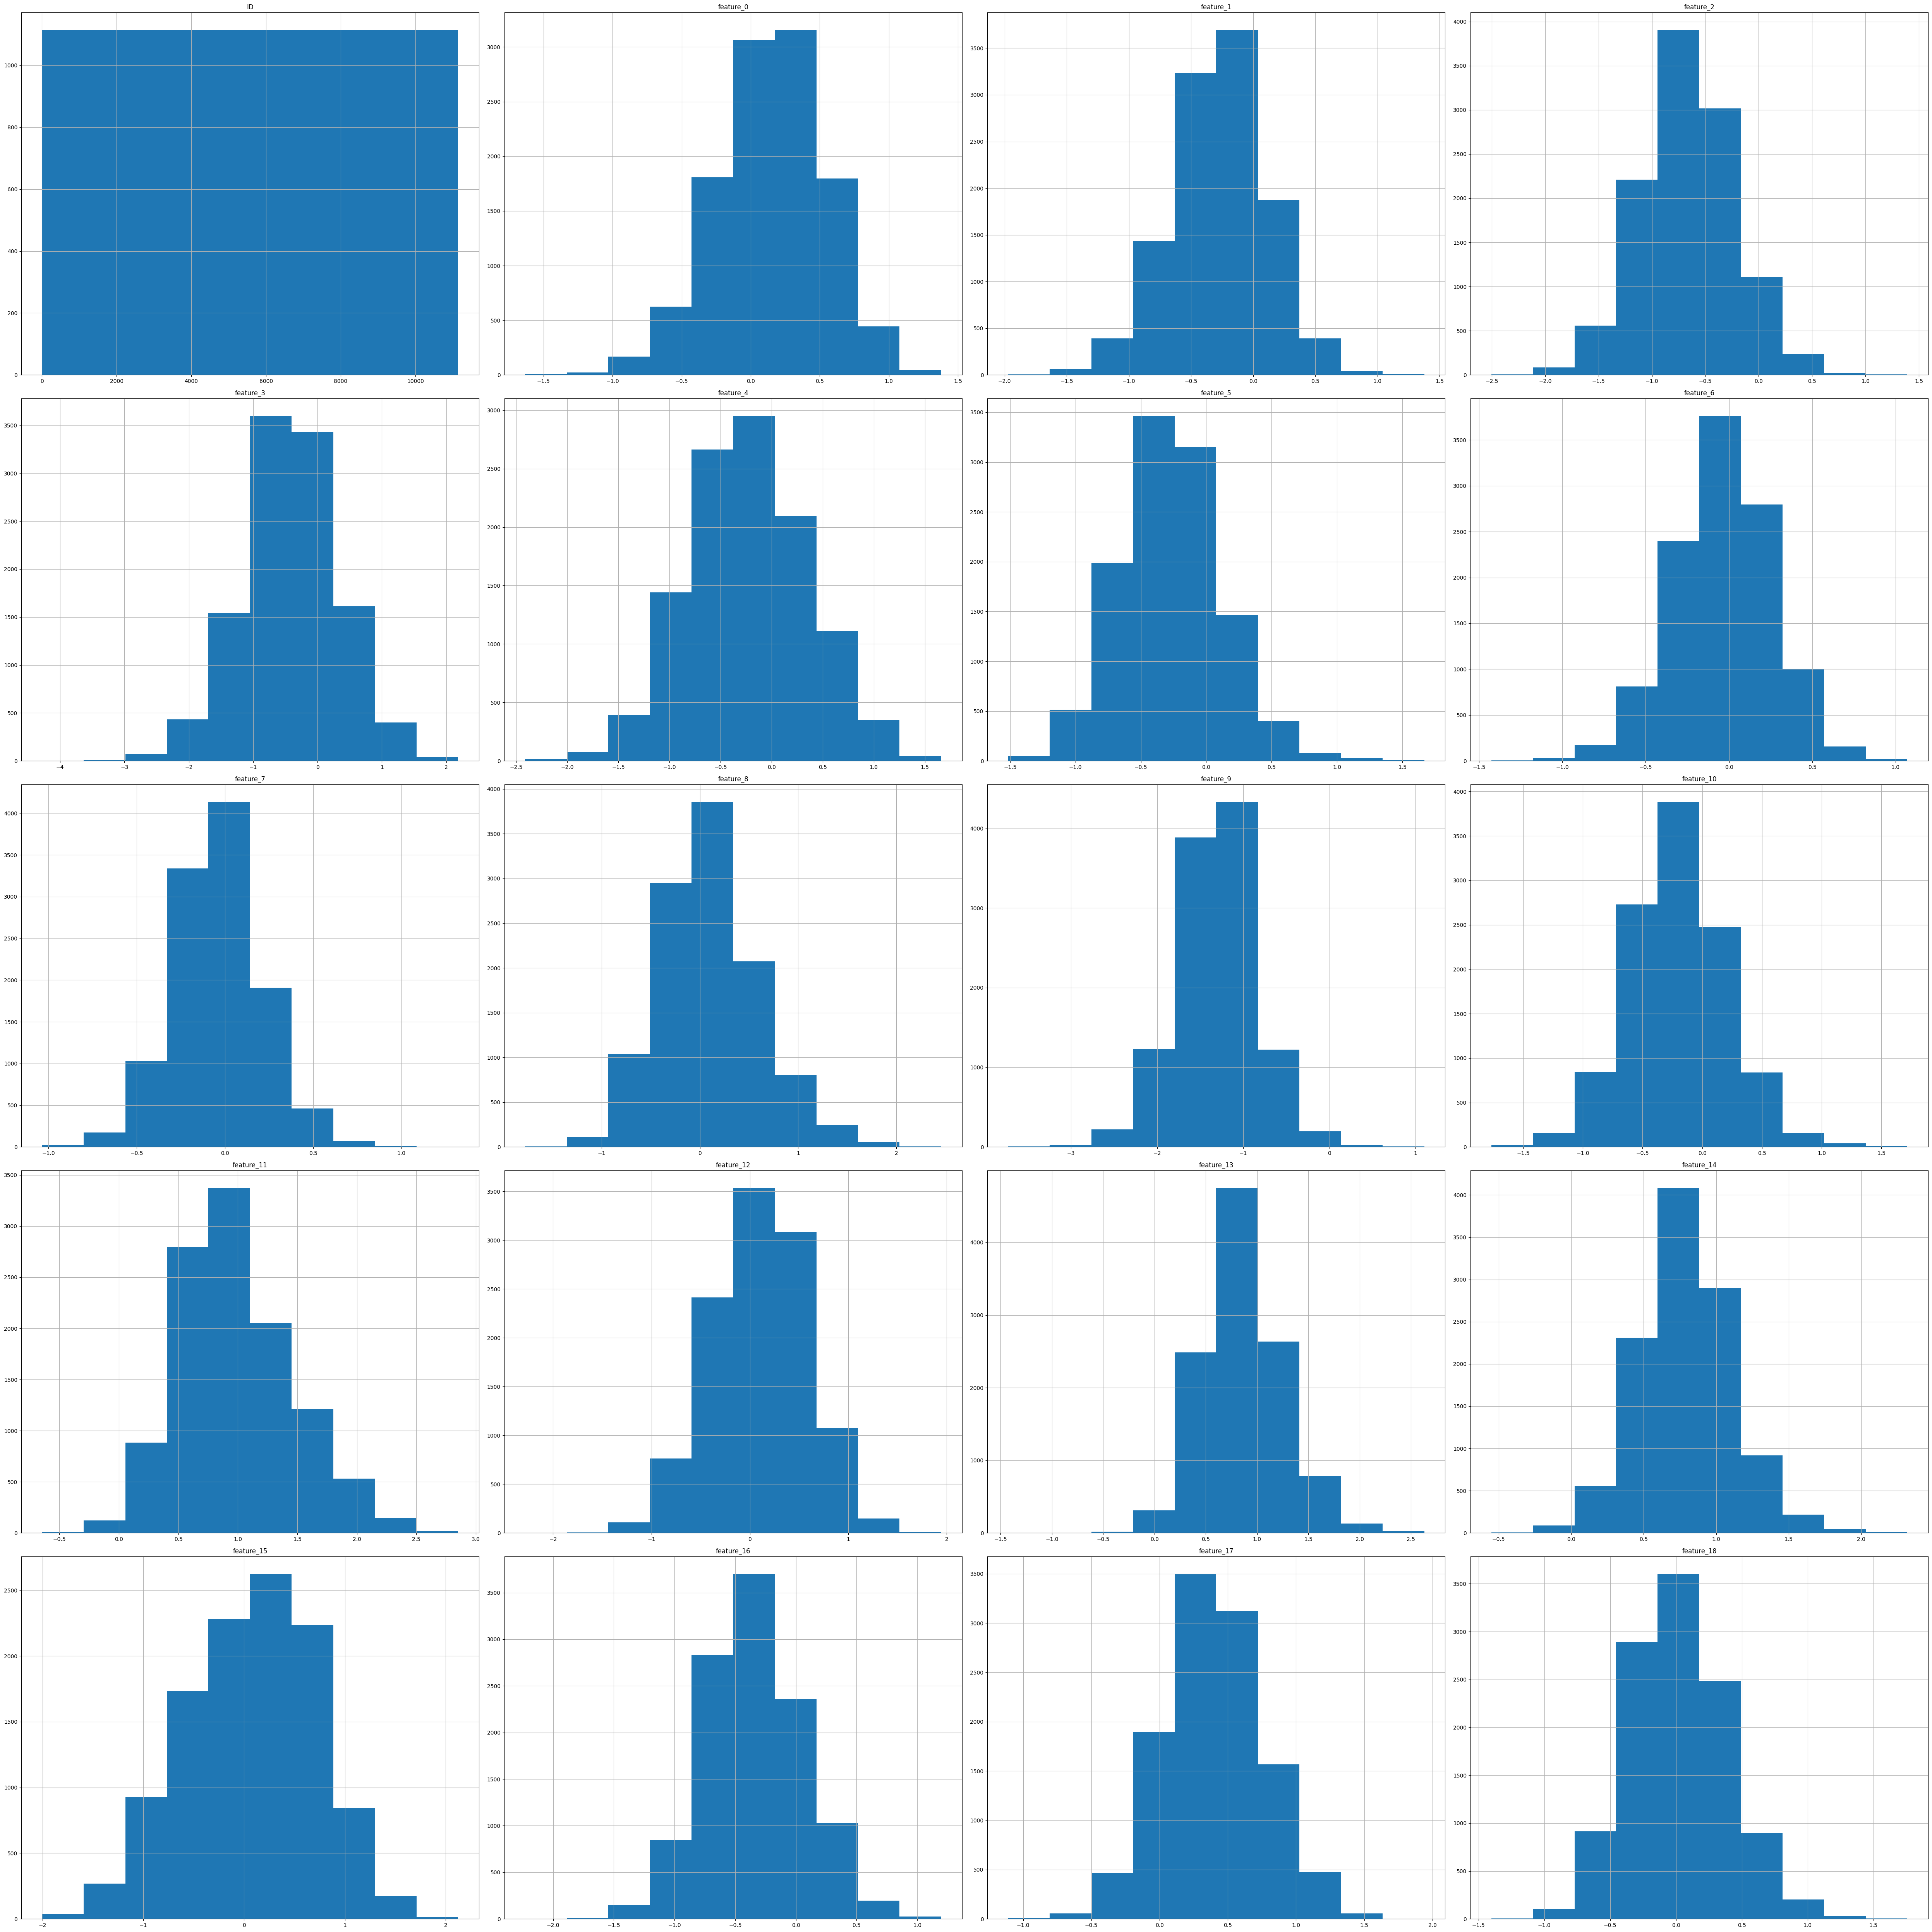

In [ ]:
# histograms
df.iloc[:,:20].hist()
plt.rcParams["figure.figsize"] = (50,50)
plt.tight_layout()
plt.show()

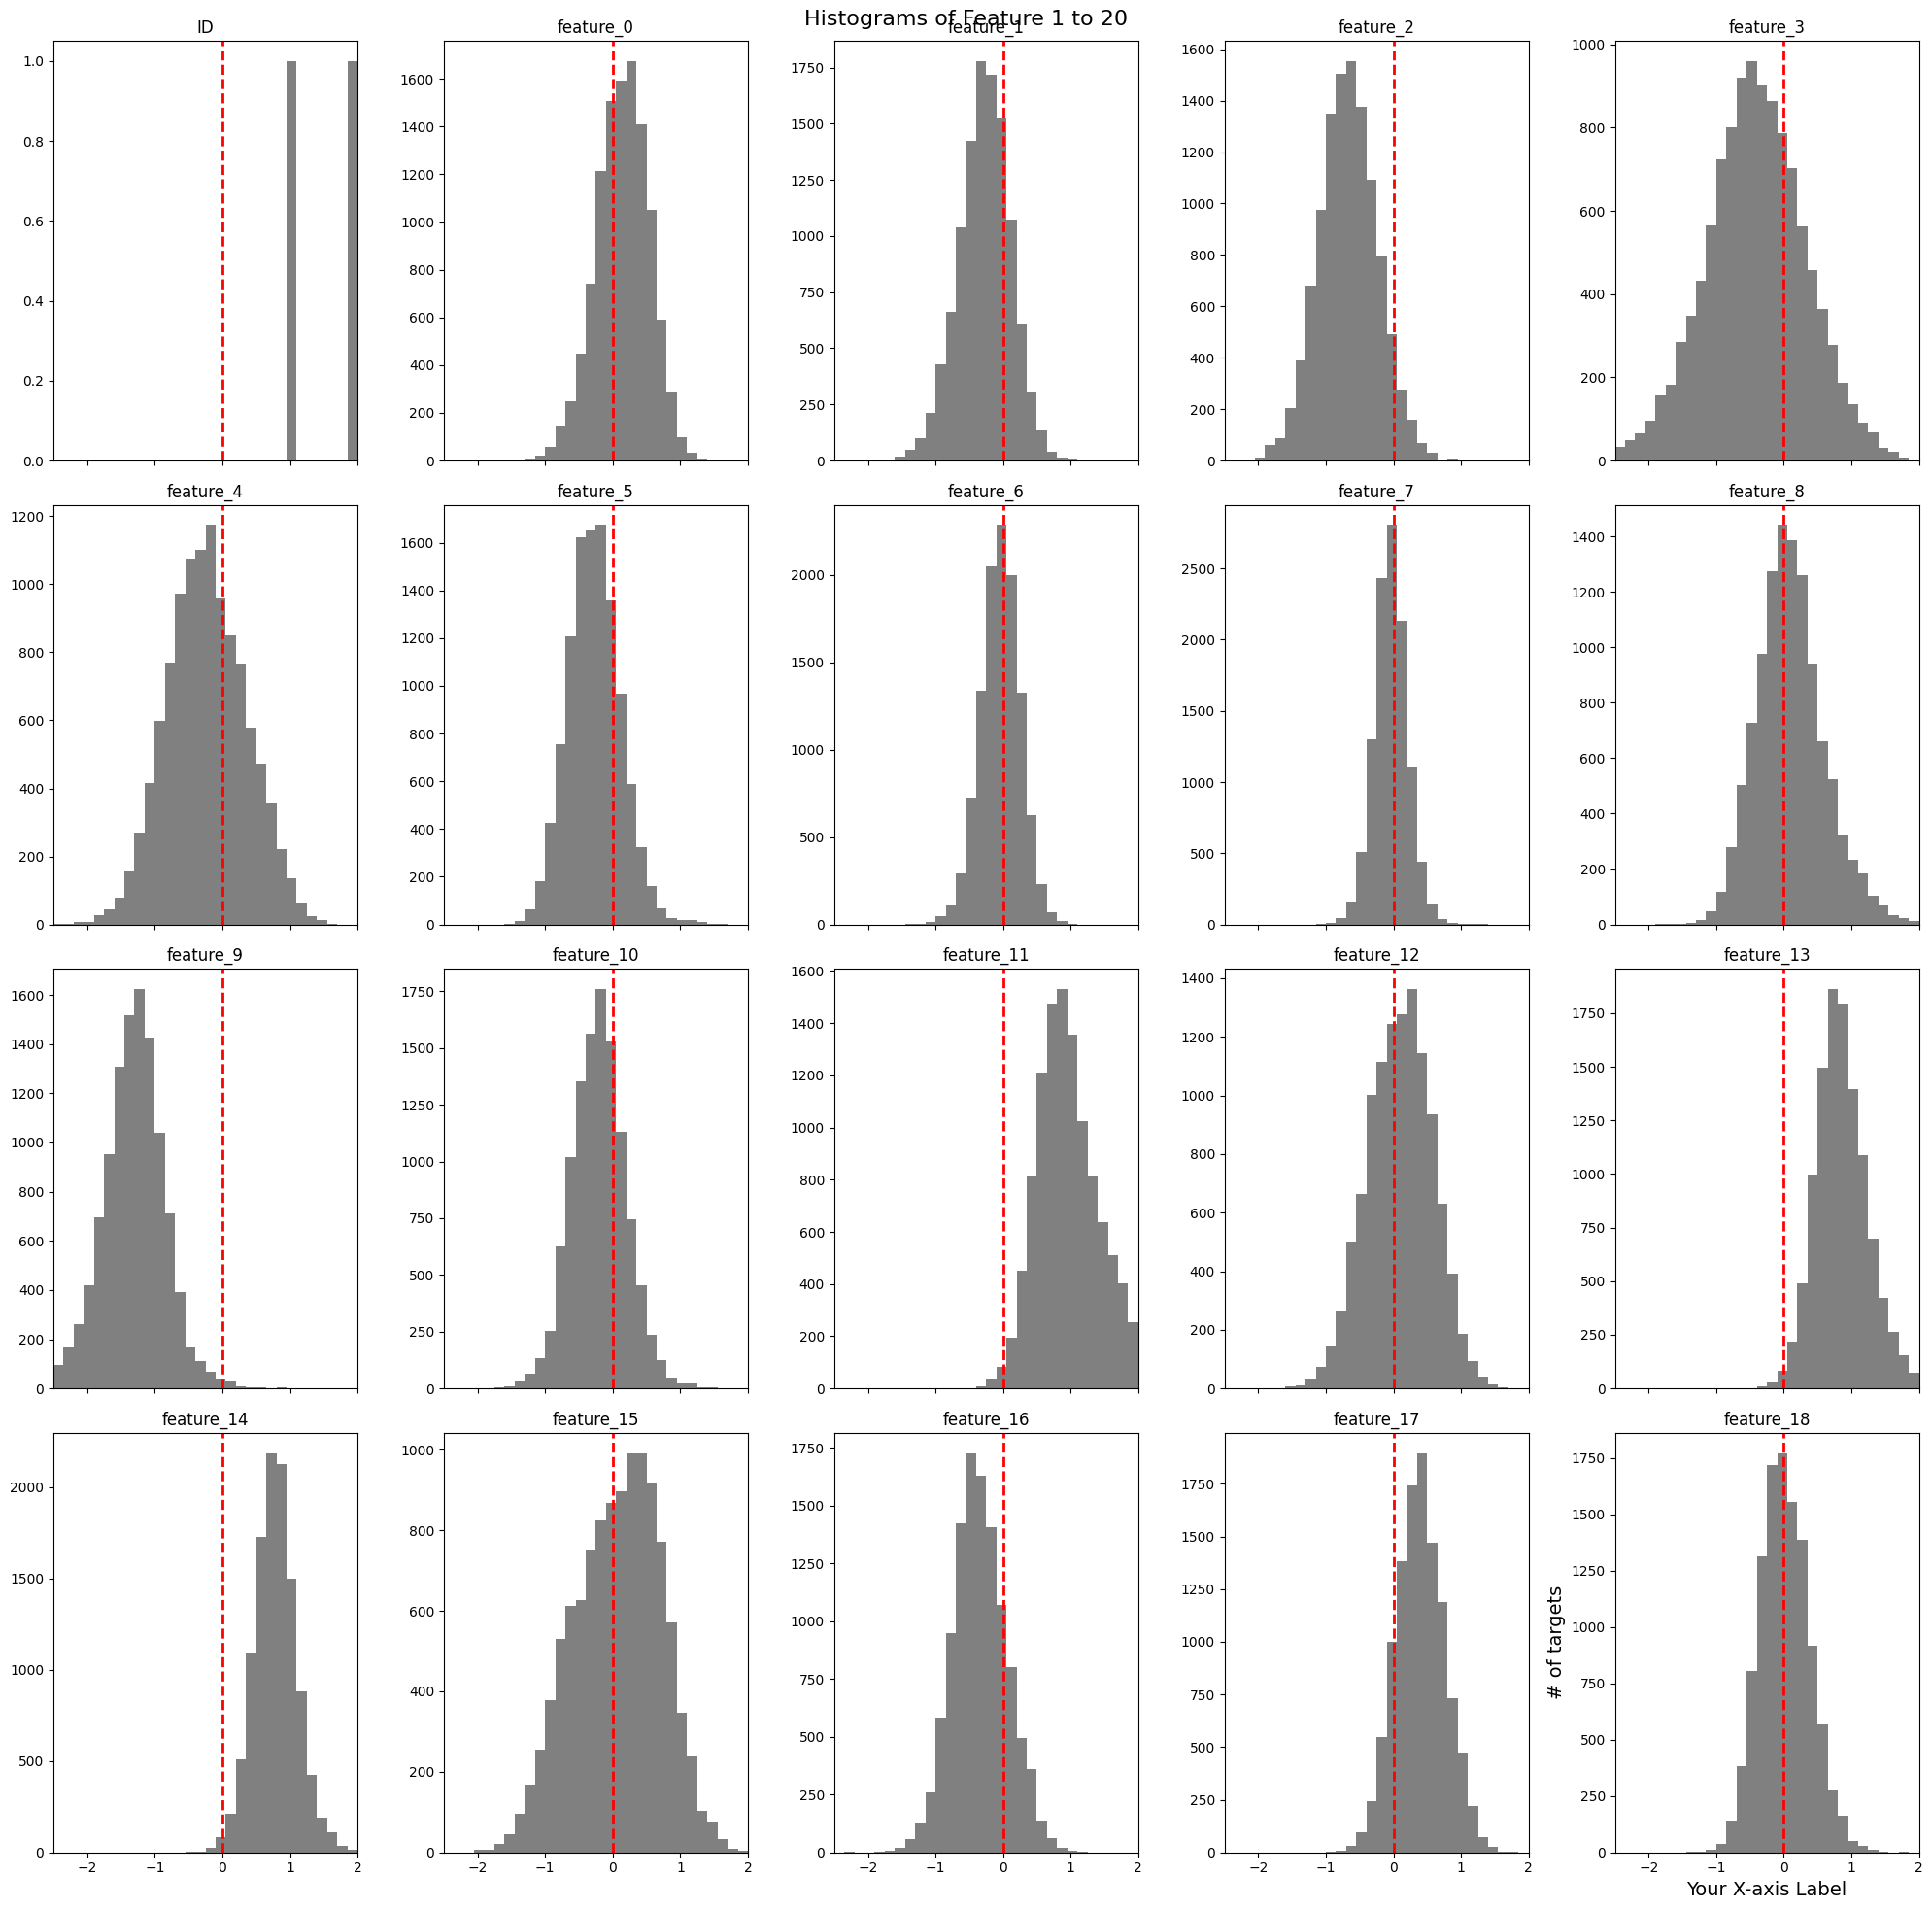

In [ ]:
# Get the number of columns you want to plot
num_cols = 20

# Set the common x-axis range
x_axis_range = (-2.5, 2.0)

# Calculate the number of rows and columns for the subplot grid
num_rows = num_cols // 5 + (num_cols % 5 > 0)  # Ceiling division

# Create subplots with a shared x-axis
fig, axes = plt.subplots(nrows=num_rows, ncols=5, sharex=True, figsize=(20, 20))

# Plot histograms for each column
for i in range(num_cols):
    row, col = divmod(i, 5)
    axes[row, col].hist(df.iloc[:, i], bins=30, facecolor='gray', align='mid', range=x_axis_range)
    axes[row, col].set_title(f'{df.columns[i]}')
    axes[row, col].set_xlim(x_axis_range)  # Set the x-axis range for each subplot
    axes[row, col].axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Add a vertical line at x=0

# Add labels and title
plt.xlabel('Your X-axis Label', fontsize=14)
plt.ylabel('# of targets', fontsize=14)
plt.suptitle('Histograms of Feature 1 to 20', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()



The embedding features appear to be mostly normally distributed, but it was also observed that not all features are distributed around a mean of 0.

### Word Count of Human vs AI generated Text

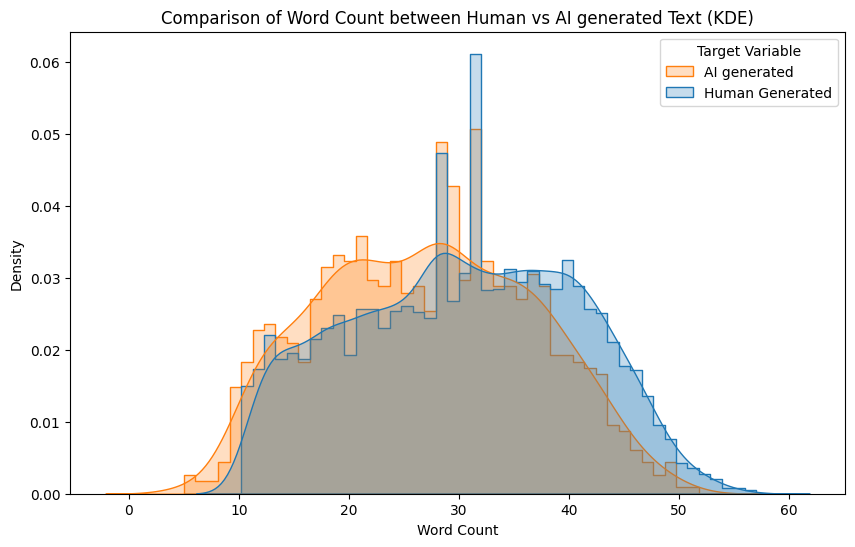

In [ ]:
# KDE plot to compare word count between target variables
plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='word_count', hue='ind', fill=True, common_norm=False)
# sns.histplot(data=df, x='word_count', hue='ind', element="step", common_norm=False, stat="density", kde=True, bins=50)
sns.histplot(data=df, x='word_count', hue='ind', element="step", common_norm=False, stat="density", bins=50)
sns.kdeplot(data=df, x='word_count', hue='ind', fill=True, common_norm=False)
plt.title('Comparison of Word Count between Human vs AI generated Text (KDE)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='Target Variable', labels=['AI generated', 'Human Generated'])
plt.show()

It can be observed that Human generated text has slightly higher number of words than AI generated text. However, there is a huge overlap between word counts of Text generated by Humans and AI.

### Punctuation Count of Human Vs AI Generated Text

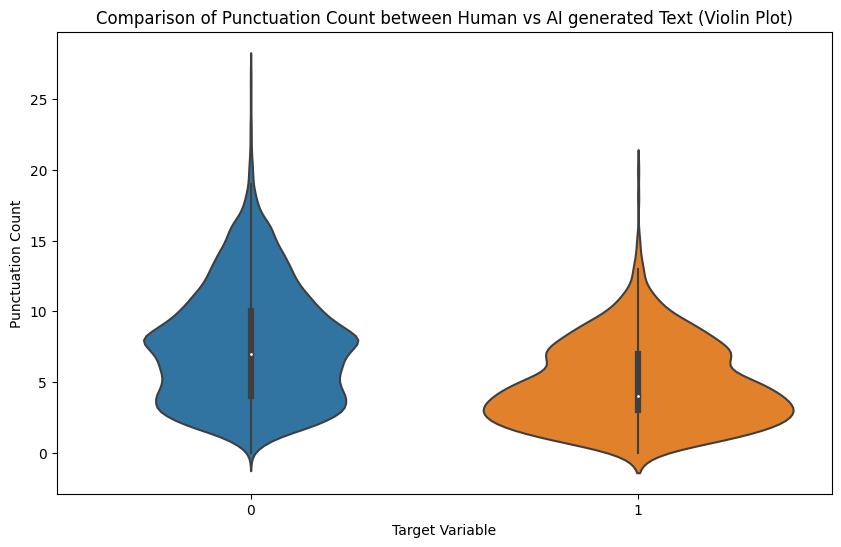

In [ ]:
# Violin plot to compare punctuation count between target variables
plt.figure(figsize=(10, 6))
sns.violinplot(x='ind', y='punc_num', data=df)
plt.title('Comparison of Punctuation Count between Human vs AI generated Text (Violin Plot)')
plt.xlabel('Target Variable')
plt.ylabel('Punctuation Count')
plt.show()

From the violin plot, it can be observed that AI generated text typically has lower punctuation count than that of Human generated text.

### Relationship between Word Count and Punctuation number

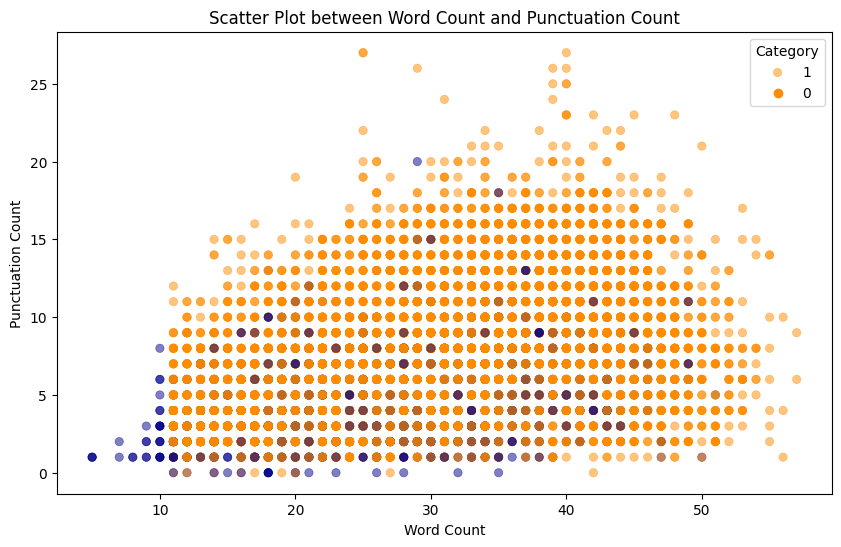

In [ ]:
# Scatter plot with different colors and light fill
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='punc_num', hue='ind', data=df, palette={1: 'darkblue', 0: 'darkorange'}, alpha=0.5, edgecolor=None)
plt.title('Scatter Plot between Word Count and Punctuation Count')
plt.xlabel('Word Count')
plt.ylabel('Punctuation Count')
plt.legend(title='Category', labels=['1', '0'])
plt.show()

There does not seem to be any increasing relationship between word count and punctuation number. Even at higher word counts like around 40-50, punctuation number ranges from as low as 0 through as high as 25.

### Variances in Embedding Features

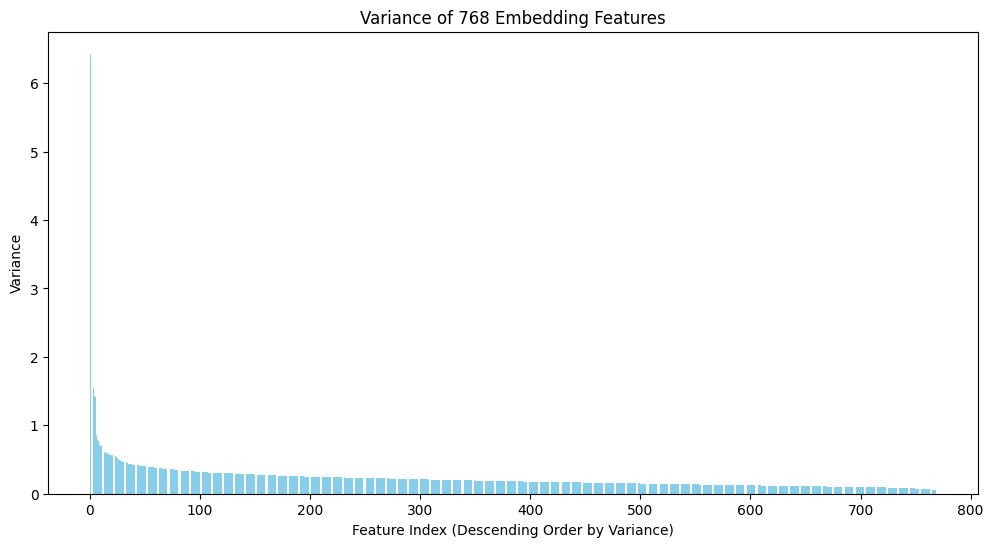

In [ ]:
embedding_feature_cols = [col for col in df.columns if 'feature' in col]
embeddings = df[embedding_feature_cols]

# Calculate variance for each feature
variances = np.var(embeddings, axis=0)

# Get the indices to sort features by variance in descending order
sorted_indices = np.argsort(variances)[::-1]

# Sort variances and feature indices accordingly
sorted_variances = variances[sorted_indices]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(variances) + 1), sorted_variances, color='skyblue')
plt.title('Variance of 768 Embedding Features')
plt.xlabel('Feature Index (Descending Order by Variance)')
plt.ylabel('Variance')
plt.show()

Most of the embedding features seem to have low variances. There are also very few embedding features that have highest variance.

### Use PCA to convert 768D to 2D for visualization

Explained Variance Ratio by top two princial Components:  [0.18221394 0.07443062]


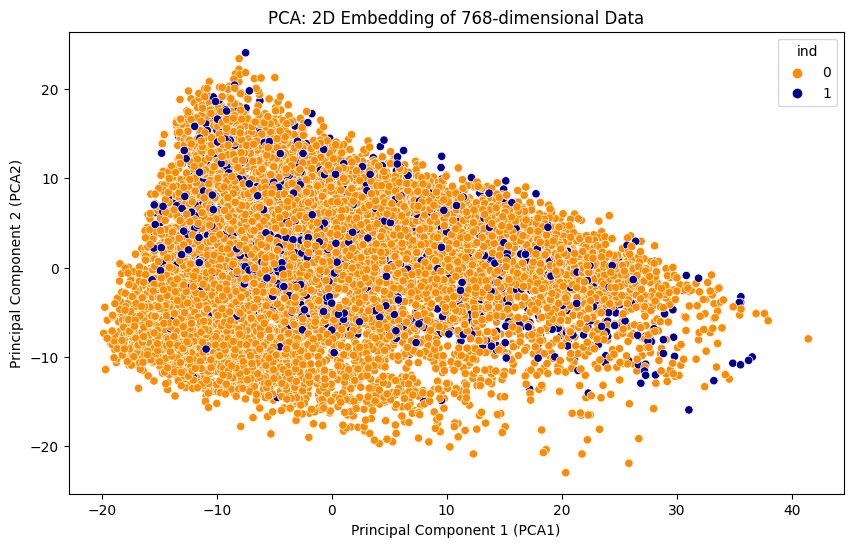

In [ ]:
embedding_feature_cols = [col for col in df.columns if 'feature' in col]
embeddings = df[embedding_feature_cols]
y_ind = df['ind']
# Standardize the features
embeddings = StandardScaler().fit_transform(embeddings)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
embeddings = pca.fit_transform(embeddings)
print("Explained Variance Ratio by top two princial Components: ", pca.explained_variance_ratio_)
# Create a DataFrame for the reduced data
df_pca = pd.DataFrame(data={'PCA1': embeddings[:, 0], 'PCA2': embeddings[:, 1], 'ind': y_ind})

# Plot the reduced data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='ind', data=df_pca, palette={0: 'darkorange', 1: 'darkblue'})
plt.title('PCA: 2D Embedding of 768-dimensional Data')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
# plt.legend(title='Category', labels=['ind=0', 'ind=1'])
plt.show()

Visualizing top two principal components that explain 25% of the variance (combined) in all the embeddings for AI vs Human generated text, we can observe that the data points are mostly overlapping and there is no clear seperation between the two clusters and model might struggle to classify just based on these two Principal Components alone. However, since this was solely for visualization purpose and including additional principal components could help in model classifying the data points better.

---



# 2.Prepare Data for Modeling

## Feature Engineering

In [ ]:
epsilon = 0.001

# creating new features from 768D sentence embeddings to improve model performance
# for col in df.columns:
#   if "feature" in col:
#     # df[col+'_word'] = df[col]/(df['word_count'])
#     # df[col+'_punc'] = df[col]/(df['punc_num']+epsilon)
#     # df[col+'_word_punc'] = df[col]/(df['punc_num']+df['word_count'])
#     df[col+'_word'] = df[col]*(df['word_count'])
#     df.drop([col],axis=1,inplace=True)
#     # pass

df['word_per_punc'] = df['word_count']/(df['punc_num']+epsilon)
df['punc_per_word'] = df['punc_num']/(df['word_count'])
df['word_plus_punc'] = df['word_count']+df['punc_num']

* The 'word_per_punc' feature represents the number of words per punctuation mark in each row, mitigating division by zero with a small constant (epsilon).
* The 'punc_per_word' feature denotes the number of punctuation marks per word.
* Lastly, the 'word_plus_punc' feature combines the counts of words and punctuation marks, offering a cumulative measure of both elements in each row.

These new features provide additional insights into the distribution and relationships between words and punctuation marks within the dataset.

## Train Test Split

In [ ]:
# Split data into X and y
X = df.drop(['ID','ind'],axis=1)
y = df['ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(11144, 773) (10029, 773) (1115, 773)
(11144,) (10029,) (1115,)


## Data Balancing

We experimented with four distinct data balancing techniques in order to balance both classes in an optimal way before modeling.

In [ ]:
# Highly imbalanced dataset - Need to balance both classes before modelling
# # Create a SMOTETomek instance
# smote_tomek = SMOTETomek(sampling_strategy='auto')
# # Fit and transform the data
# X_train, y_train = smote_tomek.fit_resample(X_train, y_train)


# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)


# undersample = RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)


oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)


#After resampling, check the shape of the data
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(18078, 773)
(18078,)
0    9039
1    9039
Name: ind, dtype: int64


After the application of SMOTETomek, the training data has been rebalanced, resulting in a resampled training set with 18,076 samples, each containing 250 features. The rebalancing ensures an equal representation of both classes, labeled as '0' and '1,' with 9,038 instances for each class.

## Standard/MinMax Scaler

Both StandardScaler and MinMaxScaler were considered and compared to achieve better results.

In [ ]:
# Initialize the Standard Scaler
# scaler = StandardScaler()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## PCA for dimensionality reduction

In [ ]:
# # apply PCA on text embeddings to reduce dimensionality
# pca = PCA(n_components = 250) #, svd_solver = 'full' #n_components = 0.95
# feature_cols=[col for col in X_train.columns if "feature" in col]
# other_cols = [col for col in X_train.columns if "feature" not in col]
# print(len(feature_cols))
# X_train_pca = pca.fit_transform(X_train[feature_cols])
# X_test_pca = pca.transform(X_test[feature_cols])
# print(pca.n_components_)
# X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i}' for i in range(pca.n_components_)])
# X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i}' for i in range(pca.n_components_)])
# X_train = pd.concat([X_train_pca, X_train[other_cols]], axis=1)
# X_test = pd.concat([X_test_pca, X_test[other_cols]], axis=1)
# print(X_train.shape)
# print(X_test.shape)

## SVD for Dimension Reduction

In [ ]:
# # Perform SVD on the training data
# feature_cols=[col for col in X_train.columns if "feature" in col]
# other_cols = [col for col in X_train.columns if "feature" not in col]
# print(len(feature_cols))
# n_components_svd = 250
# svd = TruncatedSVD(n_components=n_components_svd)  # Set the desired number of components (adjust as needed)
# X_train_svd = svd.fit_transform(X_train[feature_cols])
# X_train_svd = pd.DataFrame(X_train_svd, columns=[f'SVD_{i}' for i in range(n_components_svd)])
# # Transform the test data using the same SVD object
# X_test_svd = svd.transform(X_test[feature_cols])
# X_test_svd = pd.DataFrame(X_test_svd, columns=[f'SVD_{i}' for i in range(n_components_svd)])
# X_train = pd.concat([X_train_svd, X_train[other_cols]], axis=1)
# X_test = pd.concat([X_test_svd, X_test[other_cols]], axis=1)
# print(X_train.shape)
# print(X_test.shape)

## Lasso based feature selection

In [ ]:
#0.0012 - 500 features?
#0.0035 - 247 features

In [ ]:
# feature_cols=[col for col in X_train.columns if "feature" in col]
# other_cols = [col for col in X_train.columns if "feature" not in col]
# # Create a Lasso model
# lasso = Lasso(alpha=0.0012)  # You can adjust the alpha parameter to control the strength of regularization
# X_train_lasso = X_train[feature_cols]
# # Fit the model on the training data
# lasso.fit(X_train_lasso, y_train)
# # Get the selected features
# selected_features = X_train_lasso.columns[lasso.coef_ != 0]
# print(len(selected_features))
# X_train = pd.concat([X_train[selected_features], X_train[other_cols]], axis=1)
# X_test = pd.concat([X_test[selected_features], X_test[other_cols]], axis=1)
# print(X_train.shape)

## Random Forest based Feature Selection

In [ ]:
feature_cols=[col for col in X_train.columns if "feature" in col]
other_cols = [col for col in X_train.columns if "feature" not in col]
X_train_rf = X_train[feature_cols]
# Fit RandomForestClassifier for feature selection
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_rf, y_train)
sel = SelectFromModel(rf_classifier, threshold=-np.inf, max_features=250)
sel.fit(X_train_rf, y_train)
selected_features = X_train_rf.columns[sel.get_support()]

print(len(selected_features))
X_train = pd.concat([X_train[selected_features], X_train[other_cols]], axis=1)
X_test = pd.concat([X_test[selected_features], X_test[other_cols]], axis=1)
print(X_train.shape)
print(X_test.shape)

250
(18078, 255)
(1115, 255)


In order to address the challenge of handling over 700 features in the dataset, we explored four distinct dimensionality reduction techniques. Principal Component Analysis (PCA) and Singular Value Decomposition (SVD) were employed to transform the high-dimensional embedding features into lower-dimensional representations while preserving essential information. Additionally, we implemented Lasso-based feature selection, utilizing L1 regularization to shrink and select the most relevant features, and a random forest-based method that gauges feature importance through ensemble learning. Each technique was assessed based on its ability to contribute to the optimal outcome, and the most effective approach was chosen for further analysis and modeling.

# 3.Models

### Spot Checking

This code conducts a spot check of various classification algorithms, including Logistic Regression, K-Nearest Neighbors, Gaussian Naive Bayes, Support Vector Classifier, Decision Tree Classifier, Random Forest Classifier, and Gradient Boosting Classifier. Using 10-fold cross-validation with a random seed of 42, the code here evaluates each model on the training data, calculating the F1 score for each fold. The mean and standard deviation of these F1 scores are printed for each algorithm, providing insights into their performance on the given dataset. We aim for a comparative analysis of different classifiers to inform model selection based on cross-validated F1 scores.

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LogR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBoost', GradientBoostingClassifier()))
models

# 10-fold CV
num_folds = 10
seed = 42
scoring = 'f1'

# evaluate each model in turn
results = []
names = []
for name, model in models:
  # this makes an INDEX (between 1 and 10)
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

  # save the val results from X train
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogR: 0.845302 (0.008201)
KNN: 0.952134 (0.004094)
GNB: 0.747343 (0.005681)
SVC: 0.962864 (0.002864)
DTC: 0.962490 (0.004338)
RF: 0.998170 (0.001142)
GBoost: 0.910642 (0.007966)


[array([0.846543  , 0.84367816, 0.84261242, 0.84799131, 0.84732394,
       0.84150513, 0.82601255, 0.85083468, 0.86054054, 0.84598214]), array([0.94893617, 0.95404814, 0.95616297, 0.95400517, 0.95089045,
       0.9576087 , 0.94426581, 0.95468589, 0.95410005, 0.94663821]), array([0.74905965, 0.75082327, 0.75365344, 0.75185578, 0.73413567,
       0.75314724, 0.74646355, 0.74806801, 0.74416191, 0.74205708]), array([0.96406855, 0.96279594, 0.96468108, 0.96012759, 0.95891953,
       0.9675252 , 0.96164536, 0.95974576, 0.96178344, 0.9673492 ]), array([0.96972973, 0.96035242, 0.96330749, 0.96875   , 0.95973885,
       0.96668487, 0.96012931, 0.95872033, 0.95571576, 0.96176629]), array([0.9994429 , 0.99600228, 0.99839314, 0.99838969, 0.99661017,
       0.99774521, 0.99887892, 0.99838796, 0.99784946, 1.        ]), array([0.90340285, 0.91194616, 0.91108787, 0.92291447, 0.90697674,
       0.91020636, 0.89279824, 0.91932059, 0.91470434, 0.91306725])]


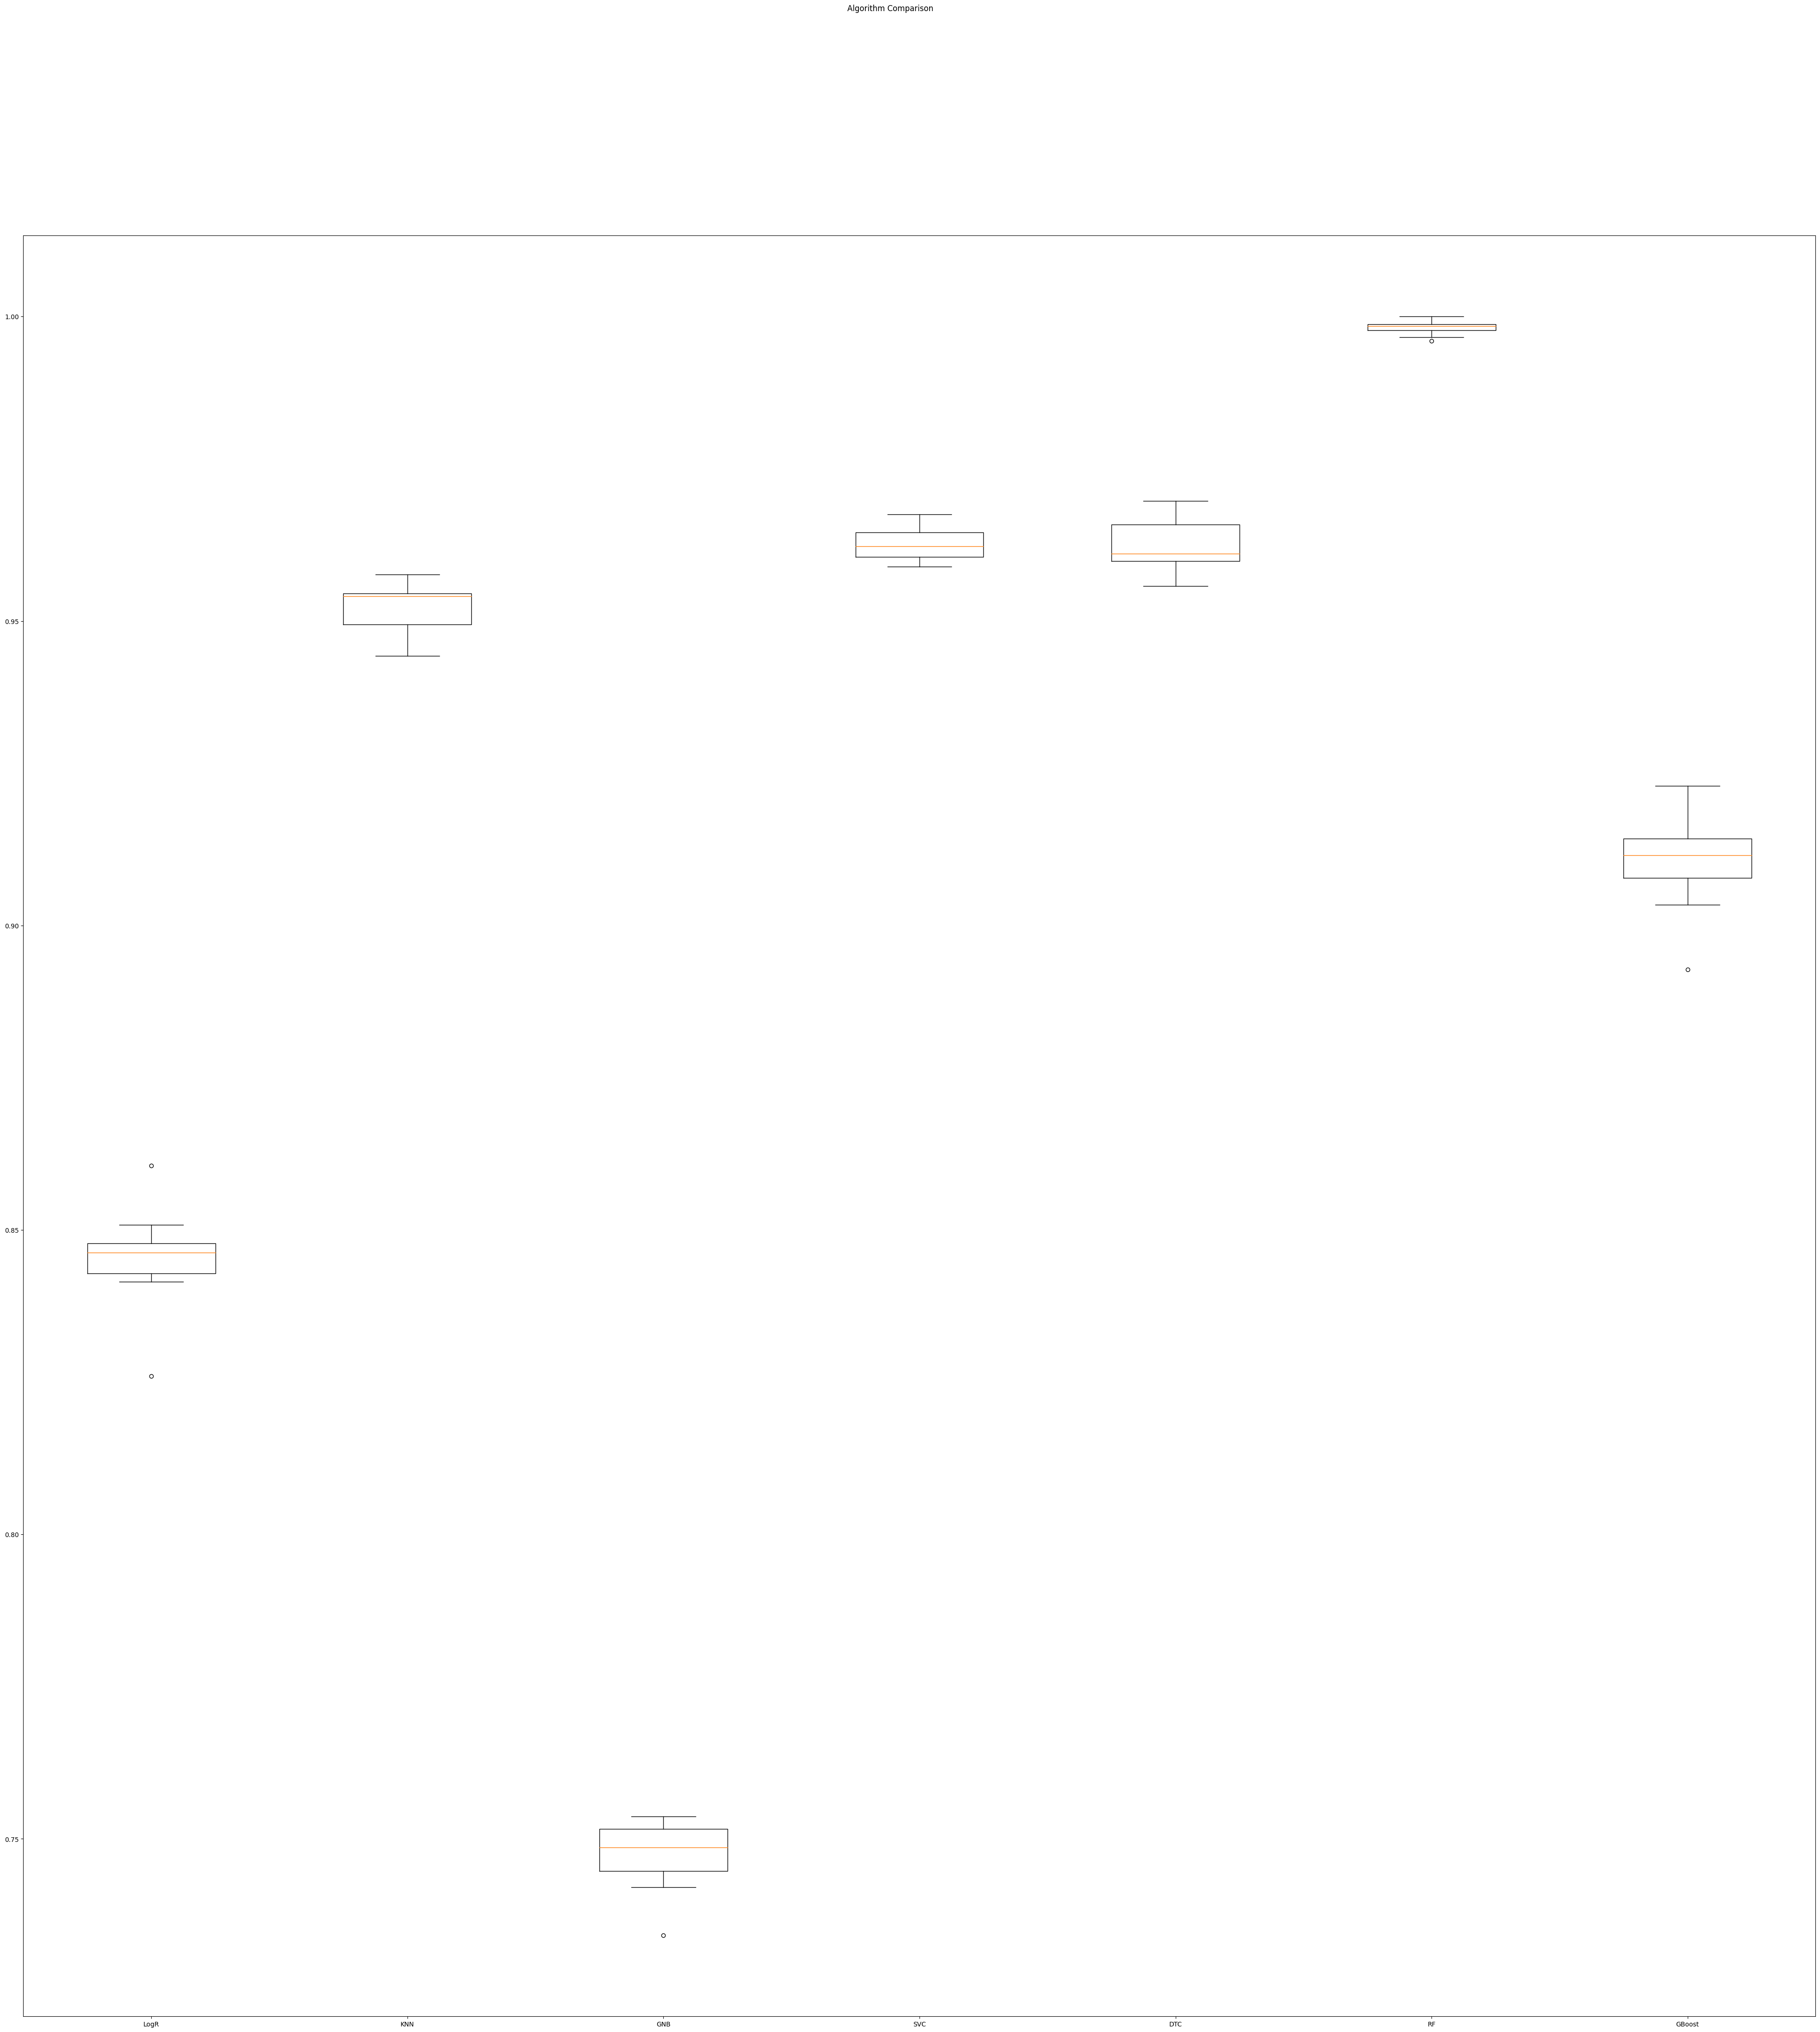

In [ ]:
print(results)
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.suptitle('Algorithm Comparison')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()



Based on the spot-checking results using default parameters, both the Support Vector Classifier (SVC) and Random Forest Classifier stand out with exceptionally high mean F1 scores  and low standard deviations , suggesting strong and consistent performance. Hence, we have concluded that conducting hyperparameter tuning for these models through GridSearchCV has the potential to enhance their performance further.

### Hyperparameter Tuning on the best models - Manual Grid Search

To identify the optimal parameters for candidate models, we conducted experiments using both grid search and AutoML.

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# model_dict = {'RF':RandomForestClassifier(random_state=42),
#               'GB':GradientBoostingClassifier(random_state=42),
#               'DT':DecisionTreeClassifier(random_state=42)}

# # Set grid search params

# # grid_params_svc = [{'C': [0.1, 1, 10],
# # 		                'kernel': ['linear', 'rbf', 'poly'],
# #                     'degree' : [2, 3, 4],
# #                     'gamma' : ['scale', 'auto', 0.1, 1]}]

# # grid_params_rf = [{'criterion': ['gini', 'entropy'],
# #                   'min_samples_leaf': [5, 10, 20, 25],
# #                   'max_depth': [3, 5, 10, 15, 20],
# #                   'min_samples_split': [5, 10, 20, 25],
# #                   'n_estimators': [30, 50, 100, 200, 500]}]

# # grid_params_gb = [{'n_estimators': [30, 50, 100, 200, 500],
# #                 'learning_rate': [0.01, 0.1, 0.2],
# #                 'max_depth' : [3, 5, 10],
# #                 'min_samples_split': [5, 10, 20, 25],
# #                 'min_samples_leaf': [5, 10, 20, 25]}]

# # grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
# #                   'clf__min_samples_leaf': [5, 10, 20, 25],
# #                   'clf__max_depth': [3, 5, 10, 15, 20],
# #                   'clf__min_samples_split': [5, 10, 20, 25]}]


# # Construct some pipelines

# # pipe_svc = Pipeline([
# # 			('clf', SVC(random_state=42))
# #    ])

# # pipe_rf = Pipeline([
# # 			('clf', RandomForestClassifier(random_state=42))
# #    ])

# # pipe_gb = Pipeline([
# # 			('clf', GradientBoostingClassifier(random_state=42))
# #    ])

# # pipe_dt = Pipeline([
# # 			('clf', DecisionTreeClassifier(random_state=42))
# #    ])


# # # Define Grid Search
# # gs_svc = GridSearchCV(estimator=pipe_svc,
# #     param_grid=grid_params_svc,
# #     scoring='f1',
# #     cv=10)

# grid_params_rf = {'criterion': ['gini', 'entropy'],
#                   'min_samples_leaf': [5, 10, 20, 25],
#                   'max_depth': [3, 5, 10, 15, 20],
#                   'min_samples_split': [5, 10, 20, 25],
#                   'n_estimators': [30, 50, 100, 200, 500]}

# grid_params_gb = {'n_estimators': [30, 50, 100, 200, 500],
#                 'learning_rate': [0.01, 0.1, 0.2],
#                 'max_depth' : [3, 5, 10],
#                 'min_samples_split': [5, 10, 20, 25],
#                 'min_samples_leaf': [5, 10, 20, 25]}

# grid_params_dt = {'clf__criterion': ['gini', 'entropy'],
#                   'clf__min_samples_leaf': [5, 10, 20, 25],
#                   'clf__max_depth': [3, 5, 10, 15, 20],
#                   'clf__min_samples_split': [5, 10, 20, 25]}


# gs_rf = RandomizedSearchCV(estimator=model_dict['RF'],
#     param_distributions=grid_params_rf,  #param_grid
#     scoring='f1',
#     cv=3,
#     n_iter=10,
#     random_state=42)

# gs_gb = RandomizedSearchCV(estimator=model_dict['GB'],
#     param_distributions=grid_params_gb,
#     scoring='f1',
#     cv=3,
#     n_iter=10,
#     random_state=42)

# gs_dt = RandomizedSearchCV(estimator=model_dict['DT'],
#     param_distributions=grid_params_dt,
#     scoring='f1',
#     cv=3,
#     n_iter=10,
#     random_state=42)


# # List of pipelines for ease of iteration
# grids = [gs_rf, gs_gb, gs_dt]


# # Dictionary of pipelines and classifier types for ease of reference
# grid_dict = {0: 'RF',
#              1: 'GB',
#              2: 'DT'}


# # Fit the grid search objects
# print('Performing model optimizations...')
# best_f1 = 0.0
# best_clf = 0
# best_gs = ''
# for idx, gs in enumerate(grids):
# 	print('\nEstimator: %s' % grid_dict[idx])
# 	# Fit grid search
# 	gs.fit(X_train, y_train)
# 	# Best params
# 	print('Best params: %s' % gs.best_params_)
# 	# Best training f1 score
# 	print('Best training f1 score: %.3f' % gs.best_score_)
# 	# Predict on test data with best params
# 	y_pred = gs.predict(X_test)
# 	# Test data f1 score of model with best params
# 	print('Test set f1 score for best params: %.3f ' % f1_score(y_test, y_pred))
# 	# Store Highest f1 score model and its parameters
# 	if f1_score(y_test, y_pred) > best_f1:
# 		best_f1 = f1_score(y_test, y_pred)
# 		best_gs = gs
# 		best_clf = idx
# print('\nClassifier with best test set f1 score: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: RF
Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 15, 'criterion': 'entropy'}
Best training f1 score: 0.987
Test set f1 score for best params: 0.576 

Estimator: GB


KeyboardInterrupt: ignored

### Auto ML and TPOT

In [ ]:
# !pip install tpot

In [ ]:
# from tpot.builtins import StackingEstimator

In [ ]:
# custom_config_dict = {

#     # # Classifiers,

#     'sklearn.ensemble.ExtraTreesClassifier': {
#         'n_estimators': [100],
#         'criterion': ["gini", "entropy"],
#         'max_features': np.arange(0.05, 1.01, 0.05),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf': range(1, 21),
#         'bootstrap': [True, False]
#     },

#     'sklearn.ensemble.RandomForestClassifier': {
#         'n_estimators': [100],
#         'criterion': ["gini", "entropy"],
#         'max_features': np.arange(0.05, 1.01, 0.05),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf':  range(1, 21),
#         'bootstrap': [True, False]
#     },

#     'sklearn.ensemble.GradientBoostingClassifier': {
#         'n_estimators': [100],
#         'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
#         'max_depth': range(1, 11),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf': range(1, 21),
#         'subsample': np.arange(0.05, 1.01, 0.05),
#         'max_features': np.arange(0.05, 1.01, 0.05)
#     },

#     'sklearn.svm.LinearSVC': {
#         'penalty': ["l1", "l2"],
#         'loss': ["hinge", "squared_hinge"],
#         'dual': [True, False],
#         'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#         'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
#     },


#     'xgboost.XGBClassifier': {
#         'n_estimators': [100],
#         'max_depth': range(1, 11),
#         'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
#         'subsample': np.arange(0.05, 1.01, 0.05),
#         'min_child_weight': range(1, 21),
#         'n_jobs': [1],
#         'verbosity': [0]
#     },

# }

In [ ]:
# from tpot import TPOTClassifier
# import time

# # Construct and fit TPOT classifier
# start_time = time.time()

# tpot = TPOTClassifier(config_dict=custom_config_dict, generations=5, max_time_mins = 60, random_state=42,  verbosity=2)
# tpot.fit(X_train, y_train)
# end_time = time.time()

# # Results
# print('TPOT classifier finished in %s seconds' % (end_time - start_time))
# print('Best pipeline test accuracy: %.3f' % tpot.score(X_test, y_test))

# # Save best pipeline as Python script file
# # make sure you update this path
# tpot.export('tpot_textclassification_pipeline.py') # this will locally download on the left



# # Average CV score on the training set was: 0.9783164267616495
# exported_pipeline = ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.45, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
# # Fix random state in exported estimator
# if hasattr(exported_pipeline, 'random_state'):
#     setattr(exported_pipeline, 'random_state', 42)


# exported_pipeline.fit(X_train, y_train)
# y_test_preds = exported_pipeline.predict(X_test)

# print(accuracy_score(y_test, y_test_preds))
# print(f1_score(y_test, y_test_preds))

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


60.20 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.45, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
TPOT classifier finished in 3651.2566595077515 seconds
Best pipeline test accuracy: 0.935


The best pipeline consists of a Gaussian Naive Bayes classifier with specific hyperparameters (alpha=0.001 and learning_rate_init=0.001). The test accuracy of this pipeline is reported at 93.2%.

The trained pipeline achieves a high accuracy score of approximately 94.1% when evaluated on the testing set.

### Random Forest

In [ ]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42,n_estimators= 100, min_samples_split= 5, min_samples_leaf= 5, max_depth= 20, criterion= 'entropy')

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the train and test set
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Evaluate the model
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

# Print the results
print("Confusion Matrix Train:\n", confusion_matrix(y_train, y_train_pred))
print("F1 Score Train:\n", f1_score(y_train, y_train_pred))
print("Classification Report Train:\n", classification_report_train)

print("Confusion Matrix Test:\n", confusion_matrix(y_test, y_test_pred))
print("F1 Score Test:\n", f1_score(y_test, y_test_pred))
print("Classification Report Test:\n", classification_report_test)

Confusion Matrix Train:
 [[9039    0]
 [   0 9039]]
F1 Score Train:
 1.0
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9039
           1       1.00      1.00      1.00      9039

    accuracy                           1.00     18078
   macro avg       1.00      1.00      1.00     18078
weighted avg       1.00      1.00      1.00     18078

Confusion Matrix Test:
 [[1001    4]
 [  70   40]]
F1 Score Test:
 0.5194805194805195
Classification Report Test:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1005
           1       0.91      0.36      0.52       110

    accuracy                           0.93      1115
   macro avg       0.92      0.68      0.74      1115
weighted avg       0.93      0.93      0.92      1115



When RFC was applied to the test set, significant change was made particularly in accurately classifying instances of the minority class (1). The confusion matrix highlights a considerable number of false negatives, leading to a very low recall value. The F1 score for the test set stands at 0.52, indicating a trade-off between precision and recall. Despite the high overall accuracy of 93%, there is apparent room for improvement, especially in enhancing the model's ability to correctly identify positive instances in the test set.

### XGBoost

In [ ]:
# Create a Random Forest classifier
xgb_classifier = xgb.XGBClassifier( random_state=42,learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.75) #objective="binary:logistic",

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the train and test set
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

# Evaluate the model
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

# Print the results
print("Confusion Matrix Train:\n", confusion_matrix(y_train, y_train_pred))
print("F1 Score Train:\n", f1_score(y_train, y_train_pred))
print("Classification Report Train:\n", classification_report_train)

print("Confusion Matrix Test:\n", confusion_matrix(y_test, y_test_pred))
print("F1 Score Test:\n", f1_score(y_test, y_test_pred))
print("Classification Report Test:\n", classification_report_test)

Confusion Matrix Train:
 [[8990   49]
 [   0 9039]]
F1 Score Train:
 0.9972968500027583
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      9039
           1       0.99      1.00      1.00      9039

    accuracy                           1.00     18078
   macro avg       1.00      1.00      1.00     18078
weighted avg       1.00      1.00      1.00     18078

Confusion Matrix Test:
 [[985  20]
 [ 47  63]]
F1 Score Test:
 0.6528497409326425
Classification Report Test:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1005
           1       0.76      0.57      0.65       110

    accuracy                           0.94      1115
   macro avg       0.86      0.78      0.81      1115
weighted avg       0.94      0.94      0.94      1115



In the test set, XGBoost achieved an overall accuracy of 94%, indicating its general effectiveness. However, it tends to struggle more with correctly identifying instances of class 1, as shown by the higher count of false negatives and lower precision and recall for this class. XGB results in better recall and f1 score when compared to Random Forest model.

### SVM Classifier

In [ ]:
best_params_svm = {'C':1, 'max_iter':1000000, 'kernel': 'rbf'}

svm_classifier = SVC(**best_params_svm, random_state=42, probability = True)

# svm_classifier = SVC( random_state=42, probability = True)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the train and test set
y_train_pred = svm_classifier.predict(X_train)
y_test_pred = svm_classifier.predict(X_test)

# Evaluate the model
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

# Print the results
print("Confusion Matrix Train:\n", confusion_matrix(y_train, y_train_pred))
print("F1 Score Train:\n", f1_score(y_train, y_train_pred))
print("Classification Report Train:\n", classification_report_train)

print("Confusion Matrix Test:\n", confusion_matrix(y_test, y_test_pred))
print("F1 Score Test:\n", f1_score(y_test, y_test_pred))
print("Classification Report Test:\n", classification_report_test)

Confusion Matrix Train:
 [[8805  234]
 [ 103 8936]]
F1 Score Train:
 0.9814926684606514
Classification Report Train:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      9039
           1       0.97      0.99      0.98      9039

    accuracy                           0.98     18078
   macro avg       0.98      0.98      0.98     18078
weighted avg       0.98      0.98      0.98     18078

Confusion Matrix Test:
 [[963  42]
 [ 30  80]]
F1 Score Test:
 0.689655172413793
Classification Report Test:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1005
           1       0.66      0.73      0.69       110

    accuracy                           0.94      1115
   macro avg       0.81      0.84      0.83      1115
weighted avg       0.94      0.94      0.94      1115



In the test set, SVM demonstrates strong overall performance with an accuracy of 94%. Precision and recall values are pretty balanced with this model and F1 score of this model surpasses all other existing models.

# 4.Evaluation

### Confusion Matrix

In [ ]:
#create confusion matrix for train and test partitions
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
print(confusion_train)
print(confusion_test)

[[8805  234]
 [ 103 8936]]
[[963  42]
 [ 30  80]]


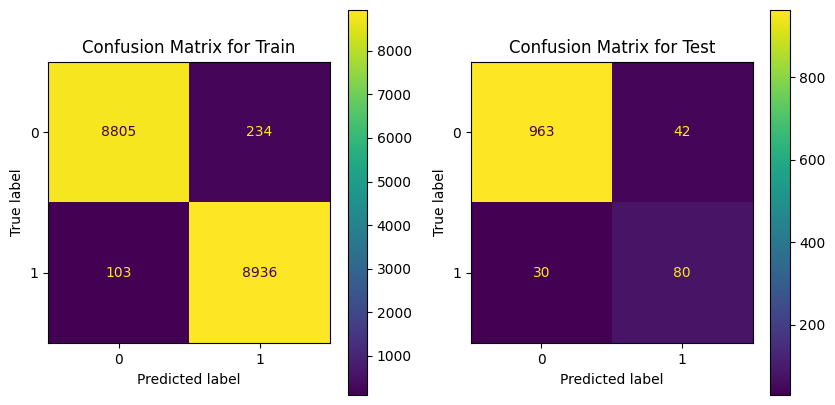

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

#Display confusion matrix for Train
display_train = ConfusionMatrixDisplay(confusion_train, display_labels=[0,1])
ax[0].set(title='Confusion Matrix for Train')
display_train.plot(ax=ax[0])


#Display confusion Matrix for Test
display_test = ConfusionMatrixDisplay(confusion_test, display_labels=[0,1])
ax[1].set(title='Confusion Matrix for Test')
display_test.plot(ax=ax[1])

For the training set:
* True Negatives (TN): 8805 instances were correctly classified as human-generated text (target 0).
* False Positives (FP): 234 instances were misclassified as AI-generated text (target 1).
* False Negatives (FN): 104 instances were misclassified as human-generated text (target 0).
* True Positives (TP): 8936 instances were correctly classified as AI-generated text (target 1).

For the test set:
* True Negatives (TN): 963 instances were correctly classified as human-generated text (target 0).
* False Positives (FP): 42 instances were misclassified as AI-generated text (target 1).
* False Negatives (FN): 30 instances were misclassified as human-generated text (target 0).
* True Positives (TP): 80 instances were correctly classified as AI-generated text (target 1).

### Final Model Classification Report

In [ ]:
##########  Classification Report on Train Predictions  #############
#predict on Test partitions
train_preds = svm_classifier.predict(X_train)
report = classification_report(y_train, y_train_pred)
print ("############# Train Classification Report ###############")
print(report)



##########  Classification Report on Test Predictions  #############
#predict on Test partitions
test_preds = svm_classifier.predict(X_test)
report = classification_report(y_test, y_test_pred)
print ("############# Test Classification Report ###############")
print(report)

############# Train Classification Report ###############
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9039
           1       0.97      0.99      0.98      9039

    accuracy                           0.98     18078
   macro avg       0.98      0.98      0.98     18078
weighted avg       0.98      0.98      0.98     18078

############# Test Classification Report ###############
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1005
           1       0.66      0.73      0.69       110

    accuracy                           0.94      1115
   macro avg       0.81      0.84      0.83      1115
weighted avg       0.94      0.94      0.94      1115



In [ ]:
print("Overall F1 score on Training Data: ",f1_score(y_train, y_train_pred))
print("Overall F1 score on Test Data: ",f1_score(y_test, y_test_pred))

Overall F1 score on Training Data:  0.9814926684606514
Overall F1 score on Test Data:  0.689655172413793


### Model Comparison

Rank | Model | Precision | Recall | Accuracy | Test F1 Score
--- | --- | --- | --- | --- | ---
1 | SVM | 0.66 | 0.73 | 0.94 | 0.69
2 | XGBoost | 0.76 | 0.57 | 0.94 | 0.65
3 | RFC | 0.91 | 0.36 | 0.93 | 0.52



* The Support Vector Machine (SVM) achieved the highest precision of 0.68, indicating a strong ability to correctly classify positive instances. SVM also demonstrated the highest recall at 0.73, signifying its effectiveness in capturing actual positive instances. Overall accuracy for SVM is 94%, and its F1 score is 0.70.
* XGBoost, while having a higher precision of 0.76, showed lower recall at 0.57, resulting in a slightly lower F1 score of 0.65.
* Random Forest Classifier (RFC) had the highest precision at 0.91 but a lower recall of 0.36, resulting in an F1 score of 0.52.

### Model Selection
* We explored numerous models using different combinations of techniques, including various data balancing methods, dimension reduction methodologies, and parameters.
* After numerous attempts, we concluded that SVM was the best-performing model, achieving the highest F1 score (0.70) among the models considered.

### Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
X_test.shape

(1115, 255)

In [ ]:
# (using permutation importance with 5 repeats) - to reduce the run time complexity

result = permutation_importance(svm_classifier, X_test, y_test, n_repeats=5, random_state=42)

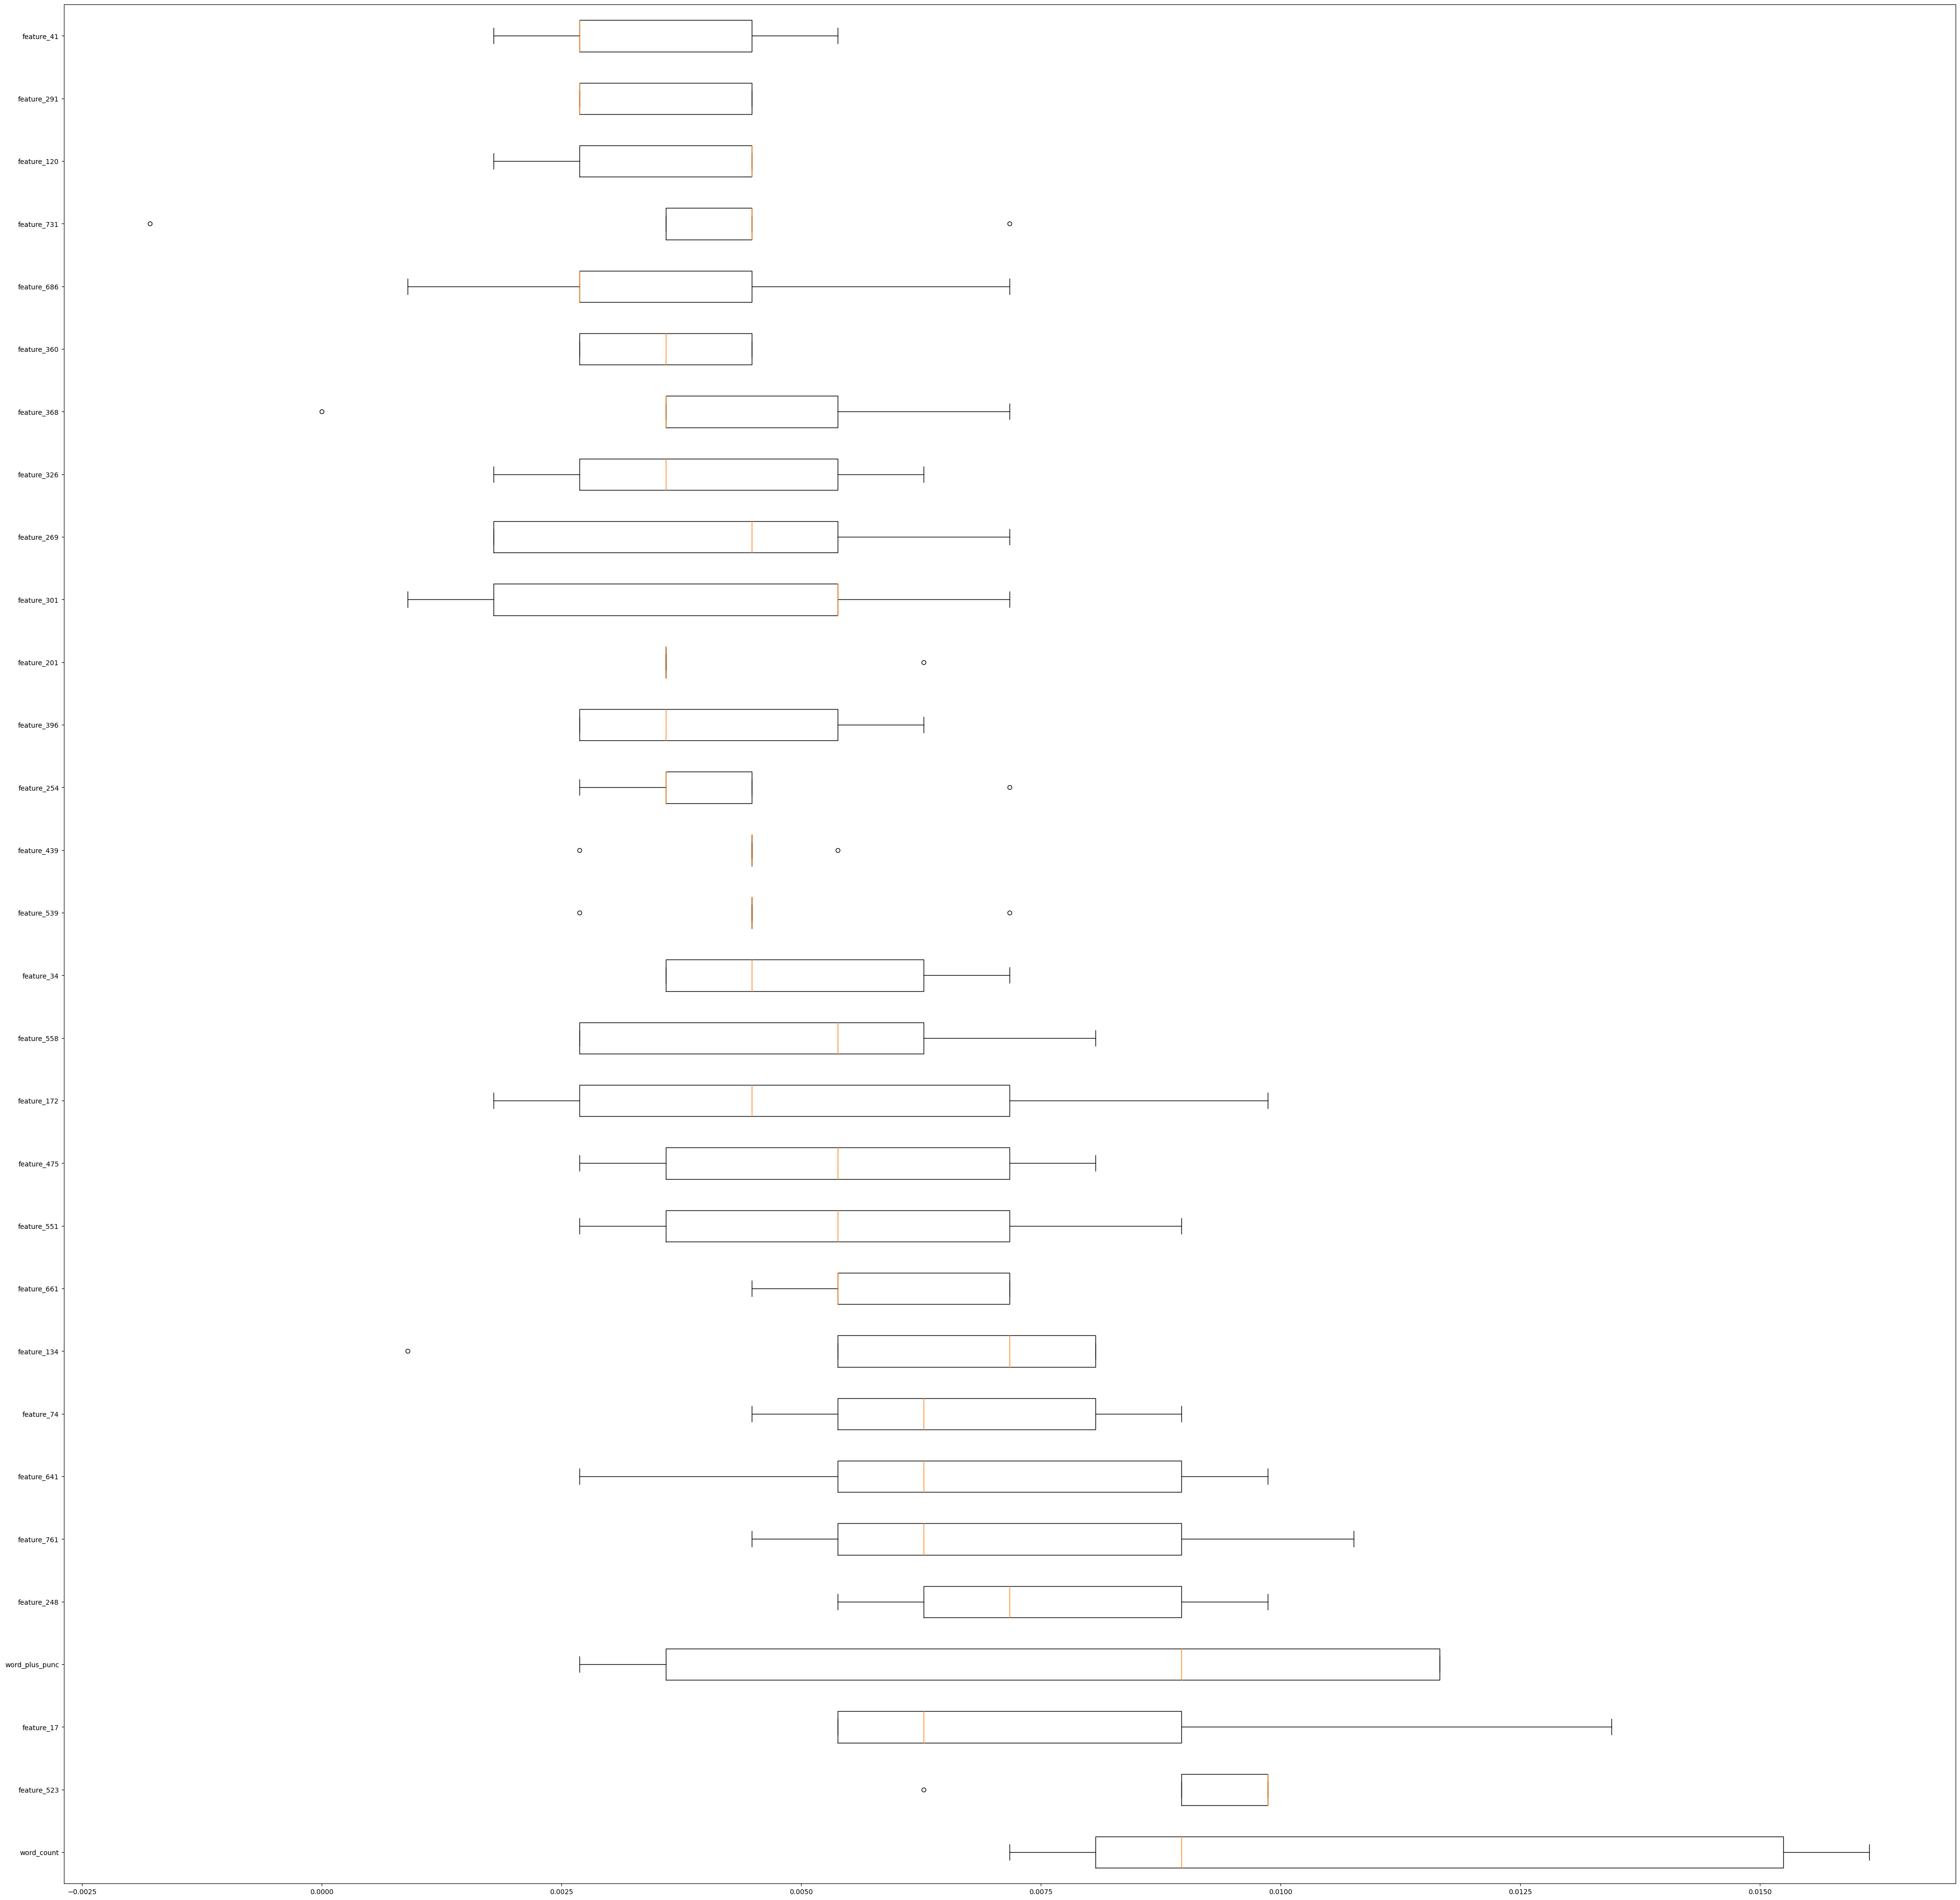

In [ ]:
# Get the feature importances and their indices
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Display the top 30 features
top_30_features = indices[:30]

plt.boxplot(result.importances[top_30_features].T, vert=False,
            labels=X_test.columns[top_30_features])
fig.suptitle('Best Model SVC Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

# 5.Discussion/ Conclusion

**1.Limitation for feature Engineering:** Since most of the data we have are sentence embeddings, its difficult to interpret these features directly and create new relevant features that can improve the model performance. Extracting meaningful insights from these features proved to be challenging. Further, there was no detail provided on how these sentence embeddings are generated. Hence this posed as a limitation in creating new features. However, we shifted our focus towards more interpretable features word_count and punc_num to create new features like punctuation density (punc_num/word_count) that can capture the number of punctuations used for a specific number of words, (word_count+punc_num), (word_count/punc_num).

**2.Dimension Reduction Experiments:** We experimented with various dimension reduction methods like PCA, SVD, Lasso based feature selection, Random Forest based Feature selection. Based on our observations, SVD performed slightly better than PCA, for a given number of components. lasso and Random Forest based feature selection outperformed SVD or PCA. Among these two, Random Forest based feature selection gave best results in terms of test f1 score. Hence we included this in our data preprocessing pipeline.

**3.Class Imbalance & Scaler Experiments:** We experimented with various class balancing techniques like SMOTE, over sampling and undersampling, SMOTETomek. Based on our observation, undersampling led to poor performance. Oversampling gave us slightly better results when compared to SMOTE & SMOTETomek. We experimented with two different types of scalers ie., standard scaler and MinMax Scaler. We found MinMax scaler performed well with our data and model chosen that standard scaler.

**4.Permutation importance:** For plotting permutation importance, we used n_repeats = 5 instead of n_repeats = 10 to reduce the runtime. Since the model is fit on ~250 features, it would take significant amount of time to refit the model multiple times for each of the feature. However by doing so, we are tolerating high variability in our model results. The top features that impacted model performance are word_count, (word_count + punc_num) and few embedding features.

**5.Time Constraint Challenges:** The extended runtime of the code on Colab presented challenges in exploring diverse model selection and optimization approaches, including spot checking, hyperparameter tuning, and AutoML. The prolonged execution times led to interruptions and extended the results' acquisition process. To mitigate this, we implemented strategies such as batch processing and code optimizations. Eventually, due to the extended processing time of grid search and AutoML, we shifted our focus to feature engineering, feature selection, and data balancing methods. Despite these challenges, we remained committed to continuously finding an efficient model, ultimately completing the project successfully. While there's a slight sense of unease about potential further improvements, we are confident that we exerted our best efforts to achieve the optimal result.

**6.Potential Business Applications:**
* Journalists and news organizations can deploy this model to combat misinformation and fake news. By leveraging the model's features, they can differentiate between AI-generated and human-written content, effectively ensuring the authenticity of information.
* E-Commerce companies can enhance their customer trust and confidence in online platforms by filtering out AI-generated product reviews. It can ultimately improve authentic product recommendations and user feedback.
